# 基本設定

In [2]:
import pandas as pd
import numpy as np
import math
import pathlib as Path

import scipy as sc
import sklearn
import pickle
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sb
sb.set(font='IPAexGothic')

# データ格納先設定
data_path = Path.Path('../data')
# 接頭辞
prefix = 'ana201'

# データ抽出
> 決済情報（df_receipt.pkl）

In [127]:
df_receipt = pd.read_pickle(data_path / 'df_receipt.pkl')
df_customer = pd.read_pickle(data_path / 'ana200_df_customer.pkl')

In [6]:
df_receipt.head()

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158
1,20181118,1542499200,S13008,1132,2,CS008415000097,P070701017,1,81
2,20170712,1499817600,S14028,1102,1,CS028414000014,P060101005,1,170
3,20190205,1549324800,S14042,1132,1,ZZ000000000000,P050301001,1,25
4,20180821,1534809600,S14025,1102,2,CS025415000050,P060102007,1,90


# データ加工

## 名寄せ

In [131]:
df = df_receipt.merge(df_customer[['customer_id', 'customer_id_nys']], on='customer_id', how='inner')
df

,sales_ymd,sales_epoch,store_cd,receipt_no,receipt_sub_no,customer_id,product_cd,quantity,amount,customer_id_nys
0,20181103,1541203200,S14006,112,1,CS006214000001,P070305012,1,158,CS006214000001
1,20170509,1494288000,S14006,112,1,CS006214000001,P071401004,1,1100,CS006214000001
2,20170608,1496880000,S14006,112,1,CS006214000001,P060104021,1,120,CS006214000001
3,20170608,1496880000,S14006,112,2,CS006214000001,P080403001,1,175,CS006214000001
4,20181028,1540684800,S14006,112,2,CS006214000001,P050102004,1,188,CS006214000001
...,...,...,...,...,...,...,...,...,...,...
65677,20171202,1512172800,S13004,1152,1,CS004613000146,P071302002,1,308,CS004613000146
65678,20180421,1524268800,S13002,1142,2,CS002314000037,P070703051,1,228,CS002314000037
65679,20180421,1524268800,S13002,1142,1,CS002314000037,P060702014,1,108,CS002314000037
65680,20190416,1555372800,S14040,1182,2,CS040311000022,P071401017,1,2200,CS040311000022


In [132]:
# 決済年月を計算
df['sales_ym'] = pd.to_datetime(df['sales_ymd'].astype('str')).dt.strftime('%Y%m')

In [140]:
# （顧客ID × 決済年月）単位に売上金額合計を計算
_rec  = df.groupby(['customer_id_nys', 'sales_ym'])['amount'].agg([('sum_amt', 'sum')]).reset_index()
_rec

,customer_id_nys,sales_ym,sum_amt
0,CS001113000004,201903,1298
1,CS001114000005,201805,438
2,CS001114000005,201907,188
3,CS001115000010,201712,2320
4,CS001115000010,201807,146
...,...,...,...
29408,CS051212000001,201910,336
29409,CS051513000004,201907,551
29410,CS051515000002,201910,265
29411,CS052212000002,201910,192


# 確認用

In [141]:
def fun_grp(x):
    d = {}
    # 顧客数
    d['cnt_cus'] = x['customer_id_nys'].count()
    # 合計金額
    d['sum_amt'] = x['sum_amt'].sum()
    # 平均金額 (1顧客あたり売上金額合計)
    d['avg_amt'] = x['sum_amt'].mean()
    # 中央値
    d['med_amt'] = x['sum_amt'].median()
    
    return pd.Series(d)

# 決済年月単位に集約
_tmp1 = _rec.groupby('sales_ym').apply(fun_grp)
_tmp1

,cnt_cus,sum_amt,avg_amt,med_amt
sales_ym,,,,
201701,860.0,618226.0,718.867442,430.0
201702,766.0,529957.0,691.849869,416.0
201703,881.0,673057.0,763.969353,435.0
201704,825.0,587741.0,712.413333,425.0
201705,843.0,598034.0,709.411625,428.0
201706,866.0,612639.0,707.435335,431.0
201707,898.0,628739.0,700.154788,426.0
201708,877.0,649852.0,740.994299,448.0
201709,786.0,583601.0,742.494911,437.0


**決済のデータ期間**\
201701 ~ 201910（計34ヶ月）

## 可視化

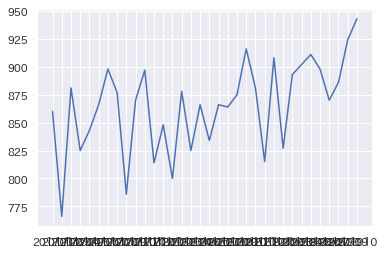

In [142]:
plt.plot(_tmp1['cnt_cus'])

月別の決済顧客UU数は直近で上昇傾向

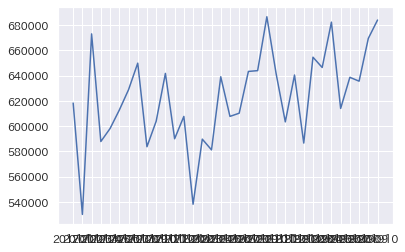

In [143]:
plt.plot(_tmp1['sum_amt'])

全体の売上傾向はやや上がっている

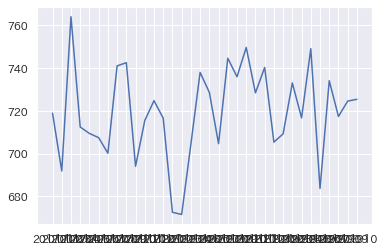

In [144]:
plt.plot(_tmp1['avg_amt'])

（平均値）顧客1当たりの売上金額は、概ね定常状態

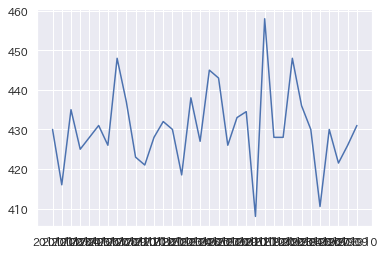

In [145]:
plt.plot(_tmp1['med_amt'])

月別売上金額の顧客中央値は、季節的な変動は見られるが概ね定常状態

# 観測期間と予測期間の設定
> 予測期間：201812 ~ 201801\
> 観測期間：201712 ~ 201701\
> \
> **注意事項：消費税の増税** \
> 1997年に5％、2014年に8％と段階的に引き上げられ、**2019年10月には10％** \
> ※微増は増税によるものかもしれない\
> ※増税付近は駆け込み需要が上がる

In [171]:
_rec['flg_predict'] = _rec['sales_ym'].apply(
    
    lambda x : 1 if 201812 >= int(x) >= 201801 else 0 if 201712 >= int(x) >= 201701 else np.nan
    
# 対象外年月をNA    
).astype('Int64')                             

In [185]:
_rec

,customer_id_nys,sales_ym,sum_amt,flg_predict
0,CS001113000004,201903,1298,<NA>
1,CS001114000005,201805,438,1
2,CS001114000005,201907,188,<NA>
3,CS001115000010,201712,2320,0
4,CS001115000010,201807,146,1
...,...,...,...,...
29408,CS051212000001,201910,336,<NA>
29409,CS051513000004,201907,551,<NA>
29410,CS051515000002,201910,265,<NA>
29411,CS052212000002,201910,192,<NA>


In [187]:
# 観測期間と予測期間の合計金額
_tmp2 = pd.pivot_table(_rec.dropna(), index='customer_id_nys', columns='flg_predict', values='sum_amt', aggfunc='sum').fillna(0).astype('Int64')
_tmp2.columns = ['sum_samt_%s' % i for i in _tmp2.columns]
_tmp2 = _tmp2.reset_index()

# 観測期間と予測期間の比率
_tmp2['rat_samt'] = np.divide(_tmp2['sum_samt_1'], _tmp2['sum_samt_0'])

# 予測期間 > 観測期間
_tmp2['flg_sts'] = np.where(_tmp2['rat_samt'] > 1, 1, 0)
_tmp2

,customer_id_nys,sum_samt_0,sum_samt_1,rat_samt,flg_sts
0,CS001114000005,0,438,inf,1
1,CS001115000010,2320,146,0.062931,0
2,CS001205000004,850,436,0.512941,0
3,CS001205000006,0,2851,inf,1
4,CS001212000027,448,0,0.0,0
...,...,...,...,...,...
7155,CS046615000004,0,190,inf,1
7156,CS047211000001,0,751,inf,1
7157,CS049115000001,0,846,inf,1
7158,CS049513000008,0,1130,inf,1


In [174]:
_tmp3 = _tmp2[
    
    # 非会員と観測期間0円、予測期間0円を除く
    (~_tmp2['customer_id_nys'].str.startswith('Z')) & (_tmp2['rat_samt'] != np.inf) & (_tmp2['rat_samt'] != 0)

].sort_values('rat_samt', ascending=False)
_tmp3

,customer_id_nys,sum_samt_0,sum_samt_1,rat_samt,flg_sts
3659,CS019415000156,140,9276,66.257143,1
6666,CS038415000123,202,7940,39.306931,1
5142,CS028515000004,348,11047,31.744253,1
4308,CS023515000153,249,7033,28.24498,1
4210,CS023414000011,178,4672,26.247191,1
...,...,...,...,...,...
1366,CS006415000147,9887,346,0.034995,0
2641,CS013515000164,5584,188,0.033668,0
2957,CS015515000034,10818,358,0.033093,0
4730,CS026414000059,7828,158,0.020184,0


In [188]:
# 目視の確認用にCSV出力
_tmp3.to_csv('chk.csv')

In [189]:
# 件数の集計
_tmp3.groupby('flg_sts').customer_id_nys.count()

flg_sts
0    1693
1    1671
Name: customer_id_nys, dtype: int64

ステータス構成は半々くらい

## 可視化

(array([2.03e+03, 6.57e+02, 2.82e+02, 1.48e+02, 6.90e+01, 4.10e+01,
        3.70e+01, 2.60e+01, 2.10e+01, 1.20e+01, 6.00e+00, 1.10e+01,
        5.00e+00, 6.00e+00, 3.00e+00, 0.00e+00, 2.00e+00, 0.00e+00,
        2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([0.019256691700365876, 1.3440144150092157, 2.6687721383180656,
        3.9935298616269153, 5.318287584935765, 6.6430453082446155,
        7.967803031553465, 9.292560754862317, 10.617318478171166,
        11.942076201480015, 13.266833924788866, 14.591591648097715,
        15.916349371406564, 17.241107094715414, 18.565864818024266,
        19.890622541333116, 21.215380264641965, 22.540137987950814,
        23.86489571

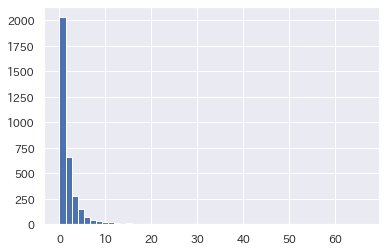

In [177]:
# 購入比率のヒストグラム
plt.hist(_tmp3['rat_samt'], bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f096e56a1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f096e56a8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f096e54ddf0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f096e55c040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f096e55c3d0>],
 'means': []}

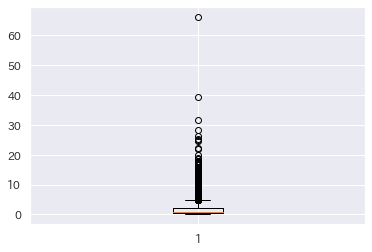

In [178]:
# 購入比率の箱ひげ図
plt.boxplot(_tmp3['rat_samt'])

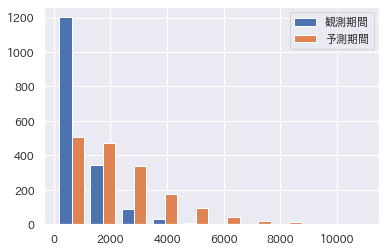

In [179]:
# ターゲット
plt.hist(
    [
        _tmp3[_tmp3['flg_sts']==1]['sum_samt_0'], _tmp3[_tmp3['flg_sts']==1]['sum_samt_1']
    ],
    label=['観測期間', '予測期間']
)
plt.legend()

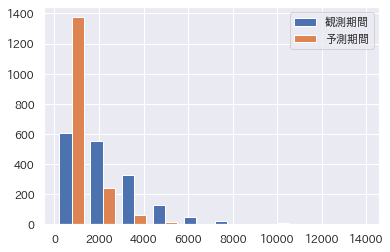

In [180]:
# 非ターゲット
plt.hist(
    [
        _tmp3[_tmp3['flg_sts']==0]['sum_samt_0'], _tmp3[_tmp3['flg_sts']==0]['sum_samt_1']
    ],
    label=['観測期間', '予測期間']
)
plt.legend()

ステータス=1\
⇒観測期間の利用金額が**低い** がゆえに予測期間の利用金額が上回った\
ステータス=0\
⇒観測期間の利用金額が**高い** がゆえに予測期間の利用金額が下回った